In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import cvxopt
from cvxopt import matrix
from cvxopt import solvers

sns.set_theme(font="Times New Roman",font_scale=1)

# Carga de Datos 

In [2]:
def load_data(symbols,start,end,freq,plot):
    # Carga de Precios

    data = pd.DataFrame({})
    for symbol in symbols:
        data_temp = yf.download(symbol, start=start, end=end,progress=False)
        data_temp.index = pd.to_datetime(data_temp.index)
        data_temp = data_temp[['Adj Close']]
        
        data = pd.concat([data,data_temp], axis=1)
        
    data.columns = symbols
    data = data.resample(freq).last()

    # Calculo de retornos logarítimicos
    data = np.log(data) - np.log(data.shift(1))
    data = data.dropna()

    if plot==True:
        data.plot(figsize=(10,7))
        if len(symbols) > 3:
            plt.legend(loc='center right', bbox_to_anchor=(1,1),
                        fancybox=True, shadow=True, ncol=5)
        plt.title("logarithmic return", loc="left", fontdict = {'fontsize':18})
        plt.show()
    return data

## Retornos de las acciones 

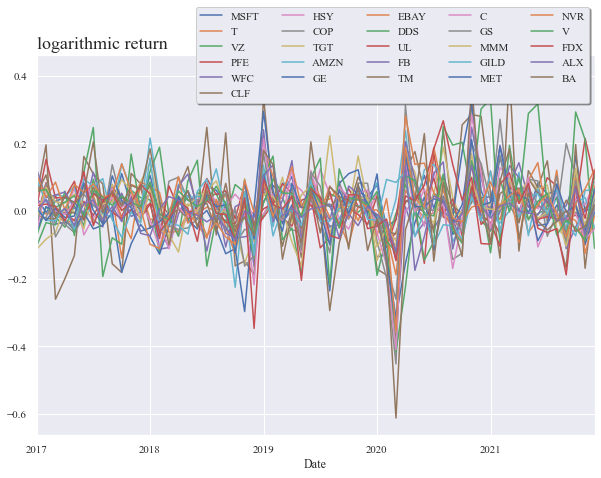

In [3]:
symbols = ["MSFT", "T", "VZ", "PFE", "WFC", "CLF", "HSY", "COP", "TGT", "AMZN", "GE", "EBAY",
"DDS", "UL", "FB", "TM", "C", "GS", "MMM", "GILD", "MET", "NVR", "V", "FDX", "ALX", "BA"]

indice = ['^GSPC']
start = '2016-12-01'
end = '2022-01-01'
freq = 'M'

retornos = load_data(symbols = symbols, start=start, end=end, freq=freq,plot=True)

## Retornos del índice 

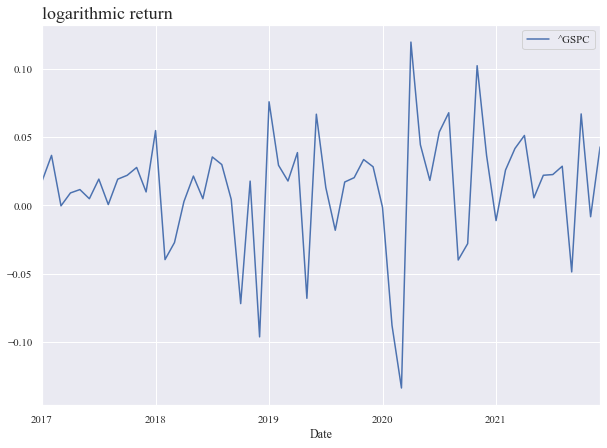

In [4]:
retornos_indice = load_data(symbols = indice, start=start, end=end, freq=freq,plot=True)

# Modelo de Treynor

In [5]:
def ols(Y,X):
    n = len(X)

    Y = np.asarray(Y).reshape((n,1))
    X = np.concatenate((
            np.ones(n).reshape((n,1)),
            np.asmatrix(X).reshape((n,1))
        ),axis=1)
    
    xtx = np.transpose(X) @ X
    xtx_x = np.linalg.inv(xtx)
    xy = np.transpose(X)@Y
    b = xtx_x @ xy
    B = np.squeeze(np.asarray(b))

    xb = X * b
    e = Y - xb
    e = np.var(e,ddof=1)
    
    return B[1], e

In [6]:
def treynor(retornos,retornos_indice):
    n = retornos.shape[1]
    betas = np.zeros(n)
    varianza_error = np.zeros(n)

    mu = retornos.agg(np.average)
    vcov = retornos.cov()
    sigma = np.sqrt(np.diag(vcov))
    rf = 0

    # regresión iterativa para los parámetros
    for i in range(n):
        betas[i], varianza_error[i] = ols(Y=retornos.iloc[:,i],X=retornos_indice)
        
    ratio_treynor = (mu-rf)/betas
    # Cálculos de los ratios 1 y 2 y las sumas acumuladas

    matriz = pd.DataFrame({
        'Ratio_treynor':ratio_treynor,
        'Betas' : betas,
        'Var_Error': varianza_error,
        'Mu': mu,
        'Sigma': sigma
    })
    matriz = matriz.sort_values(by=['Ratio_treynor'],ascending=False)

    ratio1 = np.cumsum(((matriz['Mu']-rf)*matriz['Betas'])/(matriz['Var_Error']))
    ratio2 = np.cumsum(((matriz['Betas'])**2)/(matriz['Var_Error']))

    sigma_mkt = np.std(retornos_indice)
    tasac = ((sigma_mkt**2)*ratio1)/((1+((sigma_mkt**2)*ratio2)))

    diff = matriz['Ratio_treynor'] - tasac
    cond_diff =  diff[diff>0]
    n_optimo = len(cond_diff)
    cmax = max(tasac)

    zi = (matriz['Betas']/matriz['Var_Error']) * (matriz['Ratio_treynor']-cmax)
    zi = np.maximum(zi,0)

    wpot = zi/(sum(zi))
    rpot = wpot@mu
    sigmapot = np.sqrt(wpot@vcov@wpot)

    return {'rptr':rpot, 'sigmaptr':sigmapot, 'wptr':wpot, 'n_tr':n_optimo, 'matriz':matriz}

In [7]:
treynor_portfolio = treynor(retornos=retornos, retornos_indice=retornos_indice.iloc[:,0])

rs = treynor_portfolio['rptr']
sigmas = treynor_portfolio['sigmaptr']
ws = treynor_portfolio['wptr'] 
no = treynor_portfolio['n_tr']
m = treynor_portfolio['matriz'] 
print(f"""
Retorno óptimo de Treynor:
----------------------------------------------------------------
{rs}
----------------------------------------------------------------

Riesgo óptimo de Treynor:
----------------------------------------------------------------
{sigmas}
----------------------------------------------------------------

Ponderaciones óptimas de Treynor:
----------------------------------------------------------------
{ws}
----------------------------------------------------------------

Número de acivos óptimos de Treynor:
----------------------------------------------------------------
{no}
----------------------------------------------------------------

Resumen:
----------------------------------------------------------------
{m}
----------------------------------------------------------------
""")


Retorno óptimo de Treynor:
----------------------------------------------------------------
0.026508865976389052
----------------------------------------------------------------

Riesgo óptimo de Treynor:
----------------------------------------------------------------
0.044918583376082365
----------------------------------------------------------------

Ponderaciones óptimas de Treynor:
----------------------------------------------------------------
MSFT    0.766149
HSY     0.130696
DDS     0.010992
AMZN    0.056766
TGT     0.029690
PFE     0.005706
NVR     0.000000
TM      0.000000
V       0.000000
UL      0.000000
FB      0.000000
EBAY    0.000000
GILD    0.000000
CLF     0.000000
VZ      0.000000
GS      0.000000
MET     0.000000
COP     0.000000
FDX     0.000000
BA      0.000000
MMM     0.000000
C       0.000000
WFC     0.000000
T       0.000000
ALX     0.000000
GE      0.000000
dtype: float64
----------------------------------------------------------------

Número de acivos ópt

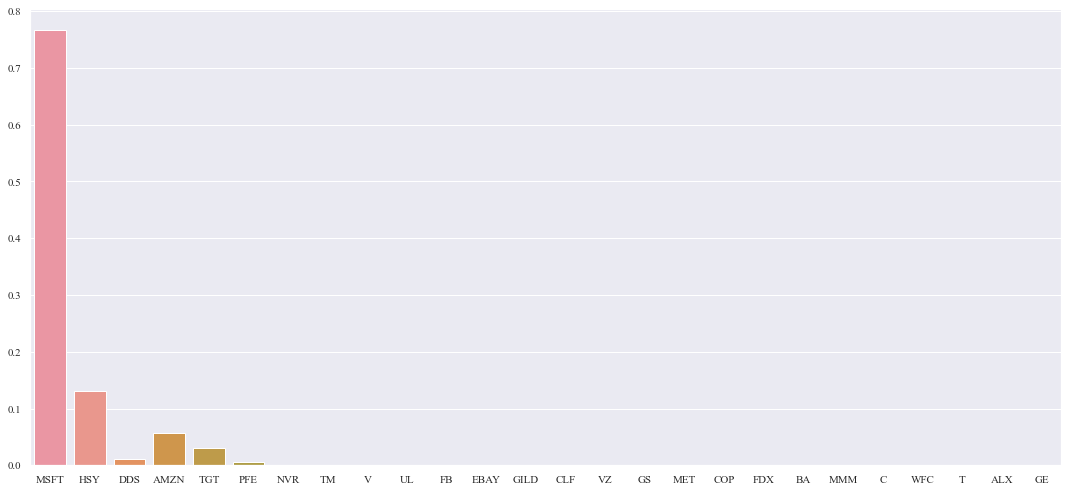

In [8]:
fig = plt.figure(figsize=(15,7))
sns.barplot(x=ws.index,y=ws)
plt.tight_layout()
plt.show()

## Frontera eficiente 

Creamos 1000 portafolios aleatorios

In [9]:
E_ri = retornos.agg(np.mean)
ddn = len(E_ri)
vcov = retornos.cov(ddof = 1)
sigma_i = np.sqrt(np.diag(vcov))

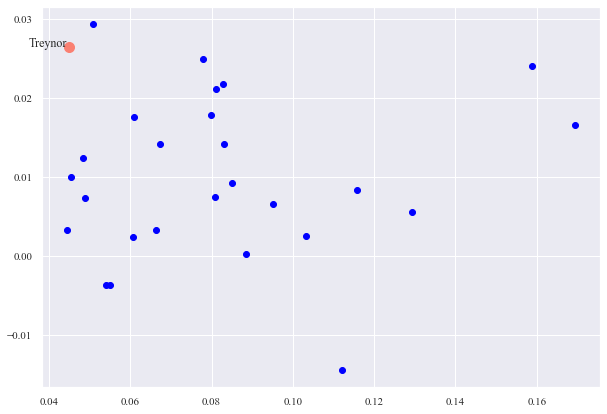

In [10]:

fig_pmv = plt.figure(figsize=(10,7))
plt.scatter(sigma_i,E_ri, color="blue")
plt.scatter(sigmas,rs, color="salmon", s=100)
plt.annotate("Treynor",xy=(sigmas,rs),xytext =(sigmas-0.010, rs))
plt.show()

# Modelo de Markowitz

In [42]:
def mv(retornos,r_target=None):
    E_ri = retornos.agg(np.mean)
    vcov = retornos.cov()
    
    n = len(E_ri)
    ones = np.ones(n)
    # zeros = np.zeros(n)
    
    # A = 1'\Sigma^{-1}E
    A = np.transpose(ones) @ np.linalg.inv(vcov) @ E_ri
    # B = E'\Sigma{-1}E
    B = np.transpose(E_ri) @ np.linalg.inv(vcov) @ E_ri
    # C = 1'\Sigma^{-1}1
    C = np.transpose(ones) @ np.linalg.inv(vcov) @ ones
    # D = BC - A^{2}
    D = B*C - A**2

    #g
    g = (1/D) * ((B * np.linalg.solve(vcov,ones))-(A * np.linalg.solve(vcov,E_ri)))
    #h
    h = (1/D) * ((C * np.linalg.solve(vcov,E_ri))-(A * np.linalg.solve(vcov,ones)))

    # reemplazando obtenemos las ponderaciones óptimas del portafolio wp
    # Asumimos como valor esperado del portafolio 
    
    if r_target != None:
        wp = g + h*r_target
    else:
        wp = np.linalg.solve(vcov,ones) * 1/C


    # Hallamos el retorno y riesgo óptimo
    rp = np.transpose(wp) @ E_ri
    sigma = np.sqrt(np.transpose(wp)@vcov@wp)

    return {'g':g,'h':h,'rp':rp,'sigma':sigma,'wp':wp}

In [43]:
E_ri = retornos.agg(np.mean)
vcov = retornos.cov()

n = len(E_ri)
ones = np.ones(n)
# zeros = np.zeros(n)

# A = 1'\Sigma^{-1}E
A = np.transpose(ones) @ np.linalg.inv(vcov) @ E_ri
# B = E'\Sigma{-1}E
B = np.transpose(E_ri) @ np.linalg.inv(vcov) @ E_ri
# C = 1'\Sigma^{-1}1
C = np.transpose(ones) @ np.linalg.inv(vcov) @ ones
# D = BC - A^{2}
D = B*C - A**2

#g
g = (1/D) * ((B * np.linalg.solve(vcov,ones))-(A * np.linalg.solve(vcov,E_ri)))
#h
h = (1/D) * ((C * np.linalg.solve(vcov,E_ri))-(A * np.linalg.solve(vcov,ones)))

# reemplazando obtenemos las ponderaciones óptimas del portafolio wp
# Asumimos como valor esperado del portafolio 

r_target = None
if r_target != None:
    wp = g + h*r_target
else:
    wp = np.linalg.solve(vcov,ones) * 1/C

In [48]:
np.linalg.solve(vcov,ones) * 1/C

array([ 0.17364436,  0.05575626,  0.15678484,  0.07637771,  0.03625486,
       -0.04686503,  0.07398397, -0.07184769, -0.01051264,  0.01649789,
        0.12307372,  0.09784791,  0.00049063,  0.12387015, -0.0184702 ,
        0.33754887, -0.20180886, -0.05998673,  0.02598759,  0.06007347,
        0.13945489, -0.04434912, -0.07819965, -0.05572114,  0.09045902,
       -0.00034505])

In [39]:
markowitz_portfolio = mv(retornos=retornos,r_target=None)
wpmv = markowitz_portfolio['wp']
rpmv = markowitz_portfolio['rp']
sigmapmv = markowitz_portfolio['sigma']
print(f"""
Pesos del portafolio de mínima varianza
{wpmv}
----------------------------------------
Retorno del portafolio de mínima varianza
{rpmv}
----------------------------------------
Riesgo del portafolio de mínima varianza
{sigmapmv}
""")


Pesos del portafolio de mínima varianza
[ 0.17364436  0.05575626  0.15678484  0.07637771  0.03625486 -0.04686503
  0.07398397 -0.07184769 -0.01051264  0.01649789  0.12307372  0.09784791
  0.00049063  0.12387015 -0.0184702   0.33754887 -0.20180886 -0.05998673
  0.02598759  0.06007347  0.13945489 -0.04434912 -0.07819965 -0.05572114
  0.09045902 -0.00034505]
----------------------------------------
Retorno del portafolio de mínima varianza
0.006980082575899904
----------------------------------------
Riesgo del portafolio de mínima varianza
0.021239877034163135



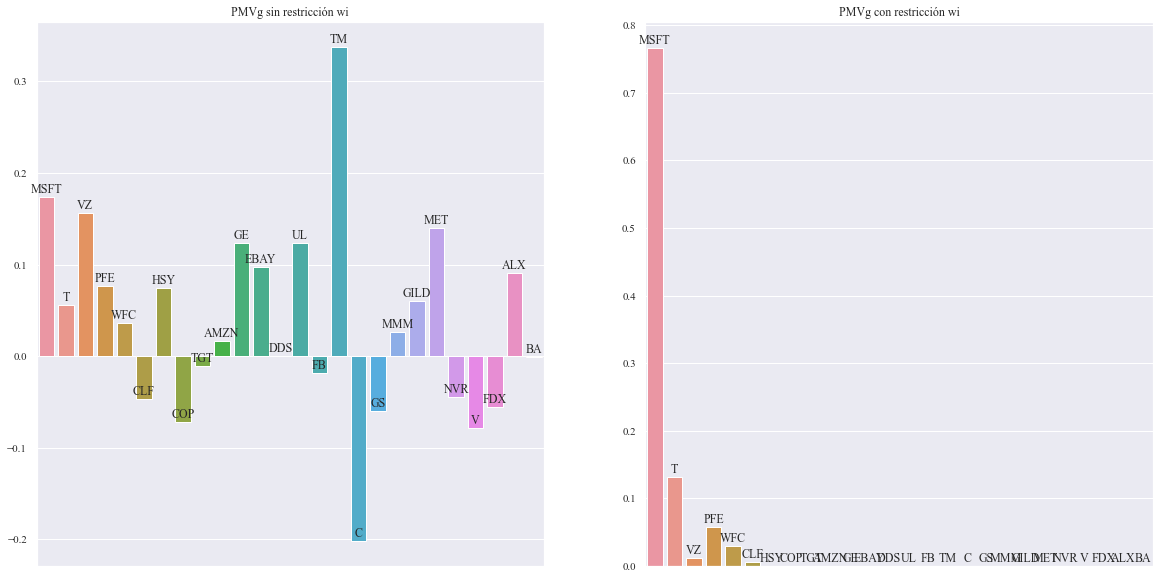

In [40]:
fig, axes = plt.subplots(1,2,figsize=(20,10))
ax1 = sns.barplot(ax=axes[0],x=retornos.columns,y=wpmv)
for p,name in zip(ax1.patches,retornos.columns):
    ax1.annotate(name,(p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 7), textcoords='offset points')
ax1.set_title('PMVg sin restricción wi')
ax1.set(xticklabels=[])

ax2 = sns.barplot(ax=axes[1],x=retornos.columns,y=ws)
for p,name in zip(ax2.patches,retornos.columns):
    ax2.annotate(name,(p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 7), textcoords='offset points')
axes[1].set_title('PMVg con restricción wi')
ax2.set(xticklabels=[])
plt.show()

In [41]:
pd.DataFrame({
    'Markowtiz' : [rpmv,sigmapmv],
    'Treynor': [rs,sigmas]
}, index= ['Retorno','Riesgo'])

,Markowtiz,Treynor
Retorno,0.00698,0.026509
Riesgo,0.02124,0.044919


Con el portafolio de mínima varianza tenemos mayor retorno dadas dos unidades menos de riesgo 

# CAPM


In [25]:
betas = []
errores = []
for i in range(retornos.shape[1]):
    b, e = ols(retornos.iloc[:,i],retornos_indice.iloc[:,0])
    betas.append(b)
    errores.append(e)

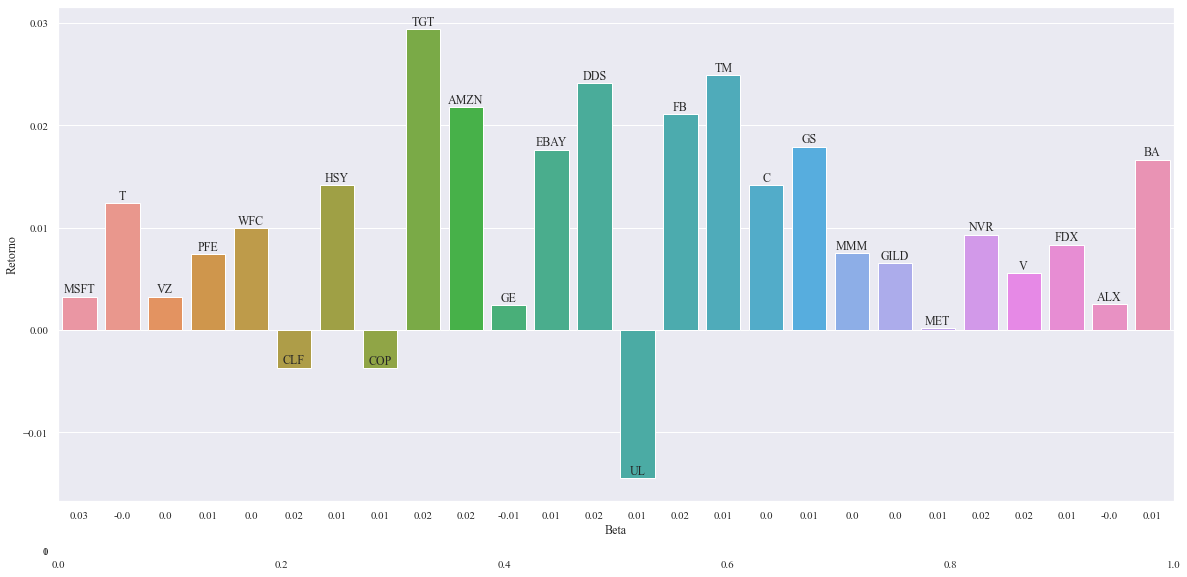

In [50]:
E_ri = retornos.agg(np.mean)
fig, axes = plt.subplots(2,1,figsize=(20,10),gridspec_kw={'height_ratios': [1, 0]})
ax1 = sns.barplot(ax=axes[0],x=betas,y=E_ri)
for p,name in zip(ax1.patches,retornos.columns):
    ax1.annotate(name,(p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 7), textcoords='offset points')
ax1.set(xticklabels=[round(i,2) for i in E_ri])
ax1.set_xlabel('Beta')
ax1.set_ylabel('Retorno')
plt.show()

## Análisis del beta 

In [51]:
# Beta de MSFT
betas[0]

0.8419737016713887

Sea el Beta de MSFT 0.841 podemos mencionar que -ceteris paribus-, se espera que el retorno de MSFT aumente en 0.841 dado un aumento del 1% en el retorno del índice.

Los betas, son considerados como parámetros de "sensibilidad", estos muestra la relación lineal entre el retronode cada activo y el retorno del índice, así, betas positivos muestran relaciones lineales proporcionales y betas negativos muestran relaciones lineales proprocionalmente negativos, en este caso se puede interpretar como la variación en $\beta_{i}$ en el retorno del activo $i$ ante variaciónes del $1\%$ en el retorno del índice.

# Desempeño 

In [69]:
# Considerando una inversión inicial de 100
C = 100

## Desempeño del Índice
port_indice = []
t = retornos_indice.shape[0]
for i in range(t):
    if i == 0:
        port_indice.append(C)
    else:
        port_indice.append(port_indice[i-1]*np.exp(retornos_indice.iloc[0][0]))

# Desempeño del portafolio de Treynor
solv_wi_target = ws
t = retornos.shape[0]
op_wi_target = np.array(np.matrix(retornos) @ solv_wi_target).reshape(-1)
port_target = []
for i in range(t):
    if i == 0:
        port_target.append(C)
    else:
        port_target.append(port_target[i-1]*np.exp(op_wi_target[i-1]))

#Retornos históricos del portafolio de mínima varianza global
t = retornos.shape[0]
op_nwi_pmv = np.array(np.matrix(retornos) @ wpmv).reshape(-1)
port_pmv = []
for i in range(t):
    if i == 0:
        port_pmv.append(C)
    else:
        port_pmv.append(port_pmv[i-1]*np.exp(op_nwi_pmv[i-1]))

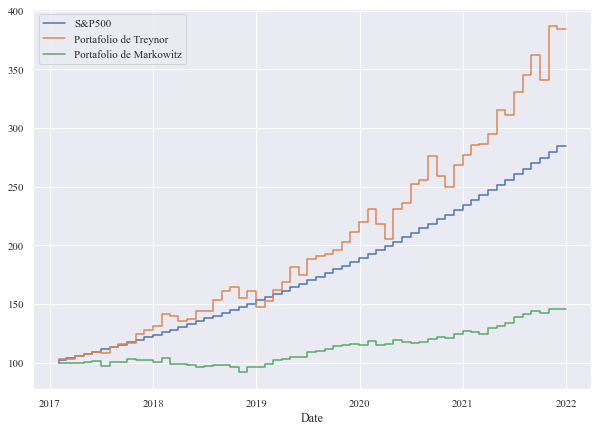

In [70]:
dates = pd.to_datetime(retornos_indice.index)
fig = plt.figure(figsize=(10,7))
sns.lineplot(x=dates,y=port_indice,label='S&P500',drawstyle='steps-pre')
sns.lineplot(x=dates,y=port_target,label='Portafolio de Treynor',drawstyle='steps-pre')
sns.lineplot(x=dates,y=port_pmv,label='Portafolio de Markowitz',drawstyle='steps-pre')
plt.show()